This is pulled from https://github.com/snap-stanford/ogb/tree/master/examples/lsc/pcqm4m

dependencies:
- install rdkit (I used conda) https://www.rdkit.org/docs/Install.html
1. conda create -c conda-forge -n my-rdkit-env rdkit
2. conda activate my-rdkit-env
3. cd [anaconda folder]/bin
4. source activate my-rdkit-env

- install ogb, torch and pytorch-geometric

- run the main-gnn.py code to download the dataset, extract and train (see the readme.md). I could finish extracting because my RAM wasn't enough. If you face the some problem, use this notebook to extract just a handful of the dataset. This code is taken from 

In [1]:
import os
import os.path as osp
import shutil
from ogb.utils import smiles2graph
from ogb.utils.torch_util import replace_numpy_with_torchtensor
from ogb.utils.url import decide_download, download_url, extract_zip
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

In [2]:
"""
my folder structure looks like (obtained from running main_gnn)
dataset/
    pcqm4m_kddcup2021/
        mapping/
        processed/
        raw/
            data.csv.gz
"""

ROOT = "dataset/pcqm4m_kddcup2021"
filename = "{}/{}".format(ROOT, "raw/data.csv.gz")
data_df = pd.read_csv(filename)
data_df

,idx,smiles,homolumogap
0,0,Cc1ccc(cc1)C1C=c2cnccc2=NC1=O,3.047675
1,1,COc1cc(OC)ccc1C=CN(C(=O)C)C,4.410966
2,2,C=CCN(C(=O)C)C=Cc1ccccc1C,4.639541
3,3,C=CCN(C(=O)C)C=Cc1ccccc1F,4.492600
4,4,C=CCN(C(=O)C)C=Cc1ccccc1Cl,4.612330
...,...,...,...
3803448,3803448,O=N(=O)c1ccc(c(c1)N(=O)=O)Cl,NaN
3803449,3803449,NCC(=O)COP(=O)(O)O,NaN
3803450,3803450,CC(CN)O,NaN
3803451,3803451,OC1C=CC=C(C1O)C(=O)O,NaN


In [3]:
"""
Load Train/Test/Valid split dictionary
"""
# INPUT PARAMETERS HERE: SET TRAIN, TEST AND VAL SIZE
trainSize = 50000
testSize = 10000
valSize = 10000

# load raw split dict
split_dict = torch.load(osp.join(ROOT, 'split_dict.pt'))
# load new split dict
new_split_dict = split_dict.copy()

# sample new split dict
new_split_dict["train"] = np.random.choice(new_split_dict["train"], size=trainSize, replace=False)
new_split_dict["test"] = np.random.choice(new_split_dict["test"], size=testSize, replace=False)
new_split_dict["valid"] = np.random.choice(new_split_dict["valid"], size=valSize, replace=False)

In [4]:
# extract train, test and valid indices
sampleIndices = np.append(
    new_split_dict["train"], [new_split_dict["test"], new_split_dict["valid"]]
)

# remap indices
idMapping = {}
for i, index in enumerate(sampleIndices):
    idMapping[index] = i
    
idMapping

{467018: 0,
 1665498: 1,
 2270317: 2,
 1112350: 3,
 12576: 4,
 2249021: 5,
 1643273: 6,
 1052232: 7,
 1044128: 8,
 2332571: 9,
 1600896: 10,
 2789567: 11,
 2267813: 12,
 765225: 13,
 2175452: 14,
 723822: 15,
 923930: 16,
 700851: 17,
 841488: 18,
 1550197: 19,
 1369921: 20,
 1076275: 21,
 831203: 22,
 1330724: 23,
 1719515: 24,
 1954292: 25,
 711593: 26,
 1646361: 27,
 2323447: 28,
 1114803: 29,
 1612010: 30,
 874229: 31,
 329054: 32,
 1033649: 33,
 1630598: 34,
 2127805: 35,
 2541518: 36,
 1484320: 37,
 1248719: 38,
 2643552: 39,
 1797759: 40,
 333856: 41,
 1679935: 42,
 1051592: 43,
 3039753: 44,
 2393048: 45,
 76254: 46,
 2758004: 47,
 907773: 48,
 1258014: 49,
 1558610: 50,
 90473: 51,
 952969: 52,
 1037404: 53,
 1781593: 54,
 176170: 55,
 2276284: 56,
 214349: 57,
 2975080: 58,
 2611508: 59,
 2186309: 60,
 46754: 61,
 2595808: 62,
 2213158: 63,
 1220227: 64,
 2356895: 65,
 2954097: 66,
 1944516: 67,
 1149775: 68,
 1721103: 69,
 1950898: 70,
 2310341: 71,
 289795: 72,
 2577348: 73

In [5]:
"""
Save New Dataframe based on smaller samples
"""
# filter dataframe
sampleDF = data_df.iloc[sampleIndices]
sampleDF["old_idx"] = sampleDF["idx"]
# remap the index
sampleDF["idx"] = sampleDF["idx"].apply(lambda x: idMapping[x])
sampleDF.index = sampleDF["idx"]

# save sample dataframe
sampleDF.to_csv(osp.join(ROOT, "raw", "sample_data.csv.gz"))

sampleDF

<ipython-input-5-66f97a946e4f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampleDF["old_idx"] = sampleDF["idx"]
<ipython-input-5-66f97a946e4f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampleDF["idx"] = sampleDF["idx"].apply(lambda x: idMapping[x])


,idx,smiles,homolumogap,old_idx
idx,,,,
0,0,C=CCNc1ccc2c(c1)B(O)OC2,4.830021,467018
1,1,N#CC(CC(C)(C)C)[N+]#[C-],8.397433,1665498
2,2,O=C[C@@H](C(=O)c1cccc(c1)OC)CN(C)C,3.847690,2270317
3,3,CC(C(=O)Cc1onc(n1)C1CC1)C,5.915755,1112350
4,4,OC(=NC1CN2CCC1CC2)C=CC(=O)O,3.140194,12576
...,...,...,...,...
69995,69995,ClCc1ccccc1S(=O)C,4.990568,3204287
69996,69996,CN1CC2C(C1)(CCCC2)c1ccccc1,5.153836,3219703
69997,69997,[N-]=[N+]=NCCCCC1ON=C(C1)C(=O)O,5.393297,3340461


In [6]:
"""
Remap split_dict indices
"""
new_split_dict["train"] = np.array([idMapping[x] for x in new_split_dict["train"]])
new_split_dict["test"] = np.array([idMapping[x] for x in new_split_dict["test"]])
new_split_dict["valid"] = np.array([idMapping[x] for x in new_split_dict["valid"]])

torch.save(new_split_dict, osp.join(ROOT, "sample_split_dict.pt"))

## load data

In [7]:
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

class SamplePygPCQM4MDataset(PygPCQM4MDataset):
    
    @property
    def raw_file_names(self):
        return 'sample_data.csv.gz'

    def process(self):
        # NOTE: CHANGED data.csv.gz to sample_data.csv.gz
        data_df = pd.read_csv(osp.join(self.raw_dir, 'sample_data.csv.gz'))
        smiles_list = data_df['smiles']
        homolumogap_list = data_df['homolumogap']

        print('Converting SMILES strings into graphs...')
        data_list = []
        for i in tqdm(range(len(smiles_list))):
            data = Data()

            smiles = smiles_list[i]
            homolumogap = homolumogap_list[i]
            graph = self.smiles2graph(smiles)
            
            assert(len(graph['edge_feat']) == graph['edge_index'].shape[1])
            assert(len(graph['node_feat']) == graph['num_nodes'])

            data.__num_nodes__ = int(graph['num_nodes'])
            data.edge_index = torch.from_numpy(graph['edge_index']).to(torch.int64)
            data.edge_attr = torch.from_numpy(graph['edge_feat']).to(torch.int64)
            data.x = torch.from_numpy(graph['node_feat']).to(torch.int64)
            data.y = torch.Tensor([homolumogap])

            data_list.append(data)

        # double-check prediction target
        split_dict = self.get_idx_split()
        assert(all([not torch.isnan(data_list[i].y)[0] for i in split_dict['train']]))
        assert(all([not torch.isnan(data_list[i].y)[0] for i in split_dict['valid']]))
        assert(all([torch.isnan(data_list[i].y)[0] for i in split_dict['test']]))

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)

        print('Saving...')
        torch.save((data, slices), self.processed_paths[0])
    
    # just modify the get_idx_split function to call our new filename
    def get_idx_split(self):
        # NOTE: CHANGED split_dict.pt to sample_split_dict.pt
        split_dict = replace_numpy_with_torchtensor(torch.load(osp.join(self.root, 'sample_split_dict.pt')))
        return split_dict

In [8]:
dataset = SamplePygPCQM4MDataset(root = 'dataset/')

  1%|          | 484/70000 [00:00<00:29, 2378.80it/s]

Processing...
Converting SMILES strings into graphs...


100%|██████████| 70000/70000 [00:30<00:00, 2333.12it/s]


Saving...
Done!


In [20]:
split_idx = dataset.get_idx_split()
split_idx["train"], split_idx["test"], split_idx["valid"]

(tensor([    0,     1,     2,  ..., 49997, 49998, 49999]),
 tensor([50000, 50001, 50002,  ..., 59997, 59998, 59999]),
 tensor([60000, 60001, 60002,  ..., 69997, 69998, 69999]))

In [15]:
evaluator = PCQM4MEvaluator()

In [28]:
import torch
from torch_geometric.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

from gnn import GNN

import os
from tqdm import tqdm
import argparse
import time
import numpy as np
import random

In [26]:
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"

In [29]:
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

In [25]:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

In [27]:
shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}


In [33]:
reg_criterion = torch.nn.L1Loss()

model = GNN(gnn_type = 'gcn', virtual_node = False, **shared_params).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f'#Params: {num_params}')

optimizer = optim.Adam(model.parameters(), lr=0.001)

best_valid_mae = 1000

scheduler = StepLR(optimizer, step_size=300, gamma=0.25)
args.epochs = 1000


#Params: 1955401


In [34]:
def train(model, device, loader, optimizer):
    model.train()
    loss_accum = 0

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        pred = model(batch).view(-1,)
        optimizer.zero_grad()
        loss = reg_criterion(pred, batch.y)
        loss.backward()
        optimizer.step()

        loss_accum += loss.detach().cpu().item()

    return loss_accum / (step + 1)

def eval(model, device, loader, evaluator):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch).view(-1,)

        y_true.append(batch.y.view(pred.shape).detach().cpu())
        y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0)
    y_pred = torch.cat(y_pred, dim = 0)

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    return evaluator.eval(input_dict)["mae"]

def test(model, device, loader):
    model.eval()
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch).view(-1,)

        y_pred.append(pred.detach().cpu())

    y_pred = torch.cat(y_pred, dim = 0)

    return y_pred

In [36]:
for epoch in range(1, args.epochs + 1):
    print("=====Epoch {}".format(epoch))
    print('Training...')
    train_mae = train(model, device, train_loader, optimizer)

    print('Evaluating...')
    valid_mae = eval(model, device, valid_loader, evaluator)

    print({'Train': train_mae, 'Validation': valid_mae})

    if valid_mae < best_valid_mae:
        best_valid_mae = valid_mae

    scheduler.step()

    print(f'Best validation MAE so far: {best_valid_mae}')


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

=====Epoch 1
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 1.4241890061874778, 'Validation': 1.5876586437225342}
Best validation MAE so far: 1.5876586437225342
=====Epoch 2
Training...


Iteration:  43%|████▎     | 84/196 [05:48<07:45,  4.15s/it]


KeyboardInterrupt: 

In [46]:
# evaluate
eval(model, device, test_loader, evaluator)

Iteration: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it]


nan

### visualise sample graphs

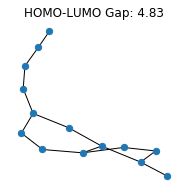

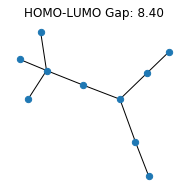

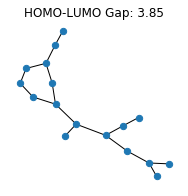

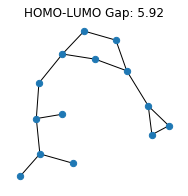

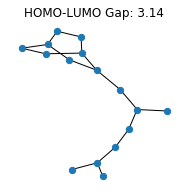

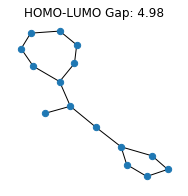

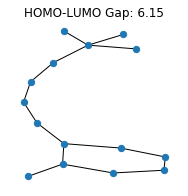

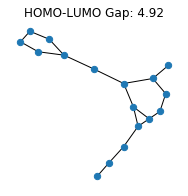

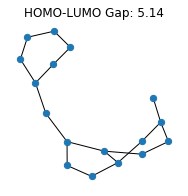

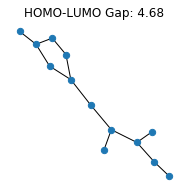

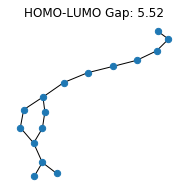

In [48]:
import networkx as nx
import matplotlib.pyplot as plt

for i in range(11):
    
    _data = dataset[i]
    edges = _data.edge_index.T.tolist()
    edges = np.array(edges)

    G = nx.Graph()
    G.add_edges_from(edges)

    plt.figure(figsize=(3, 3))
    plt.title("HOMO-LUMO Gap: {0:.2f}".format(_data.y.tolist()[0]))
    nx.draw(G, node_size=40)
    plt.show()